<a href="https://colab.research.google.com/github/FourLevel/Machine-Learning-and-Financial-Applications/blob/main/Homework%203_Random%20Forest%20on%200050%20ETF/Homework%203_Random%20Forest%20on%200050%20ETF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 0050 Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2)
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from yfinance

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [28]:
!pip install tensorflow
#!pip install tensorflow-addons
!pip install tensorflow-addons==2.12.0 type_api<=0.4.4 --force-reinstall
!pip install scikeras

/bin/bash: line 1: =0.4.4: No such file or directory


In [29]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Instead of importing from tensorflow.keras.wrappers.scikit_learn, use:
from scikeras.wrappers import KerasClassifier  # This imports KerasClassifier from scikeras
from tensorflow.keras.optimizers import SGD

<a id='1.2'></a>
## 2.2. Loading the Data

In [30]:
!pip install --upgrade yfinance==0.2.58

In [31]:
# For reading stock data from yahoo
import yfinance as yf

# For time stamps
from datetime import datetime

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

dataset = yf.download("0050.TW", start, end)
dataset.to_csv("data.csv")

[*********************100%***********************]  1 of 1 completed


In [32]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [33]:
# shape
dataset.shape

(1215, 5)

In [34]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
Date,,,,,
2025-05-12,176.70,177.0,175.50,175.50,13441939
2025-05-13,178.85,181.1,178.85,180.85,19980679
2025-05-14,182.90,182.9,181.35,181.85,22550803
2025-05-15,182.50,182.9,182.00,182.90,11419450
2025-05-16,183.00,183.2,181.70,182.25,9453933


In [35]:
# describe data
pd.set_option('display.precision', 3)  # Specify the full option name
dataset.describe()

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
count,1215.000,1215.000,1215.000,1215.000,1.215e+03
mean,129.301,129.957,128.551,129.296,1.078e+07
std,30.924,31.095,30.710,30.884,7.773e+06
min,72.573,73.011,71.873,72.661,0.000e+00
25%,110.705,111.083,110.204,110.758,5.891e+06
50%,122.461,123.318,121.787,122.734,8.665e+06
75%,136.454,137.514,135.980,136.905,1.330e+07
max,201.613,203.192,201.465,202.156,8.033e+07


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [36]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values.

In [37]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [38]:
# Drop the '0050.TW' level from the columns
dataset.columns = dataset.columns.droplevel(1)

# Reset the index to make it a single index
dataset = dataset.reset_index()

dataset.to_csv("data.csv")

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement:
* **1** if the signal is that short term price will go up as compared to the long term.
* **0** if the signal is that short term price will go down as compared to the long term.

In [39]:
# Convert 'Close' column to numeric, handling errors

dataset['Close'] = pd.to_numeric(dataset['Close'], errors='coerce')

# Fill NaNs with previous valid numeric values
dataset['Close'] = dataset['Close'].ffill()

# Initialize the `signals` DataFrame with the `signal` column
# datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=20, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

# Predict the next n day's signal
n = 3
dataset['signal'] = dataset['signal'].shift(-n)
dataset = dataset.dropna()
dataset.head()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
0,2020-05-18,72.748,73.011,72.442,72.661,8271703,72.748,72.748,0.0
1,2020-05-19,73.405,73.929,73.186,73.842,5477775,73.076,73.076,0.0
2,2020-05-20,73.317,73.667,73.055,73.492,9894141,73.157,73.157,1.0
3,2020-05-21,73.929,74.192,73.580,73.623,7568047,73.350,73.350,1.0
4,2020-05-22,72.573,73.405,72.530,73.317,13354146,73.195,73.195,1.0


In [40]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
1207,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0
1208,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0
1209,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0
1210,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0
1211,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0


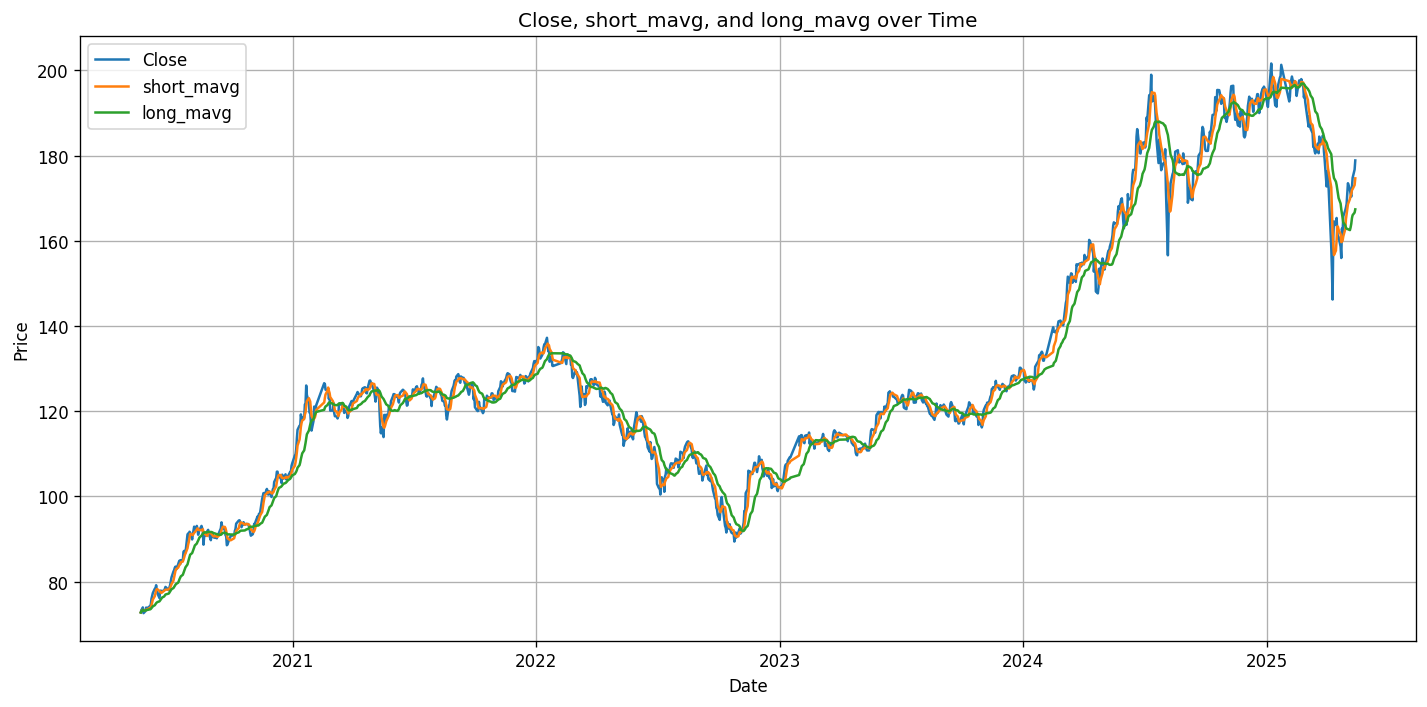

In [41]:
plt.figure(figsize=(12, 6), dpi=120)  # Adjust figure size as needed
plt.plot(dataset['Date'], dataset['Close'], label='Close')
plt.plot(dataset['Date'], dataset['short_mavg'], label='short_mavg')
plt.plot(dataset['Date'], dataset['long_mavg'], label='long_mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close, short_mavg, and long_mavg over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [42]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [43]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0,168.517,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1208,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0,169.259,...,50.901,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1209,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0,170.257,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1210,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0,171.429,...,51.429,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1211,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0,172.778,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


In [44]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0,168.517,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1208,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0,169.259,...,50.901,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1209,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0,170.257,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1210,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0,171.429,...,51.429,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1211,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0,172.778,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


In [45]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'short_mavg','long_mavg'], axis=1)

In [46]:
dataset = dataset.dropna(axis=0)

In [47]:
dataset.tail()

Price,Date,Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-05-07,170.35,13284346,1.0,168.517,169.686,177.960,4.605,-6.785,14.40,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1208,2025-05-08,172.60,9827807,1.0,169.259,169.874,177.907,6.609,-6.526,9.75,...,50.901,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1209,2025-05-09,174.75,12972096,1.0,170.257,170.189,177.875,5.430,-5.285,12.85,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1210,2025-05-12,176.70,13441939,1.0,171.429,170.609,177.863,5.713,-2.376,10.95,...,51.429,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1211,2025-05-13,178.85,19980679,1.0,172.778,171.140,177.873,6.585,-0.195,11.70,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


<a id='3.4'></a>
## 4.4. Data Visualization

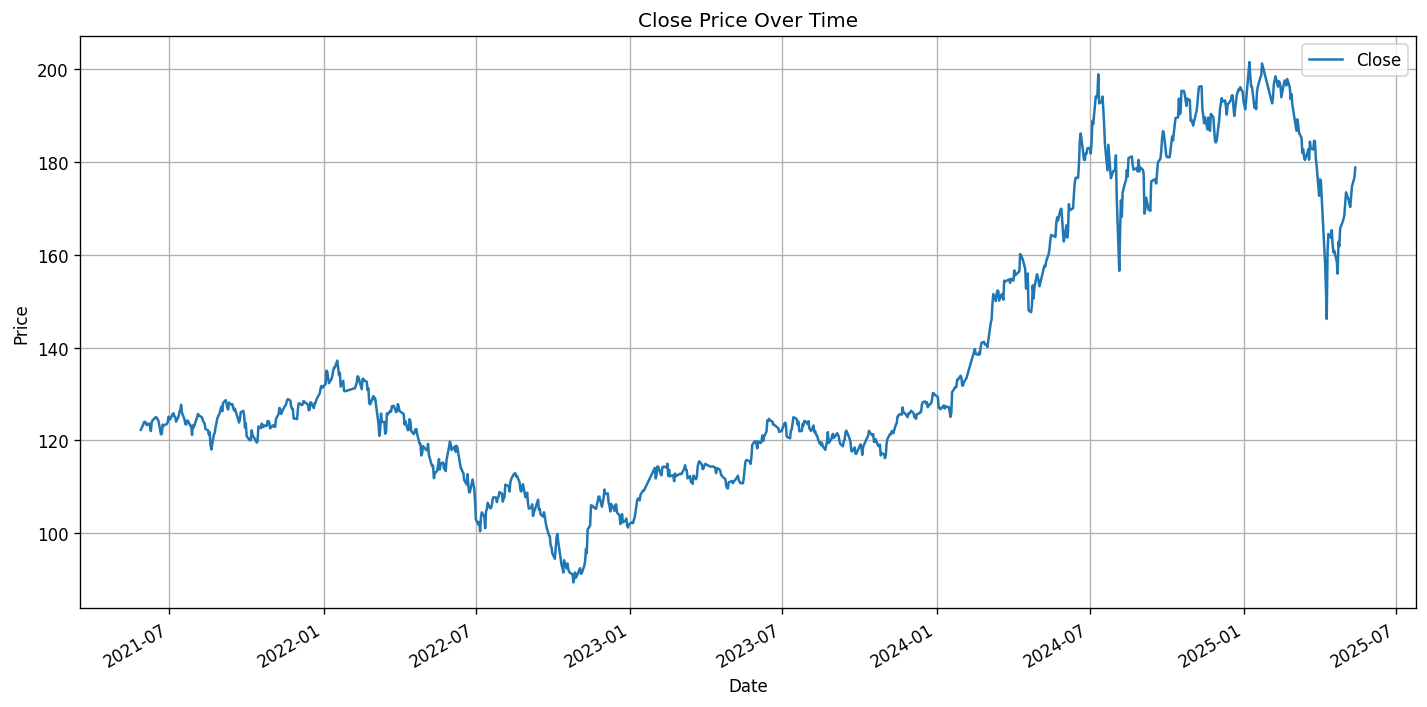

In [48]:
# Assuming 'Date' was originally the index, reset it to a column
dataset = dataset.reset_index()

# Create a new figure with a specified size and resolution (dpi)
plt.figure(figsize=(12, 6), dpi=120)

# Now you can plot on this figure
dataset.plot(x='Date', y='Close', grid=True, ax=plt.gca()) # Use ax=plt.gca() to plot on the current figure

plt.title('Close Price Over Time') # Optional: Add a title
plt.xlabel('Date') # Optional: Add x-axis label
plt.ylabel('Price') # Optional: Add y-axis label

# Display the plot
plt.tight_layout()
plt.show()

In [49]:
dataset = dataset.drop('index', axis=1)

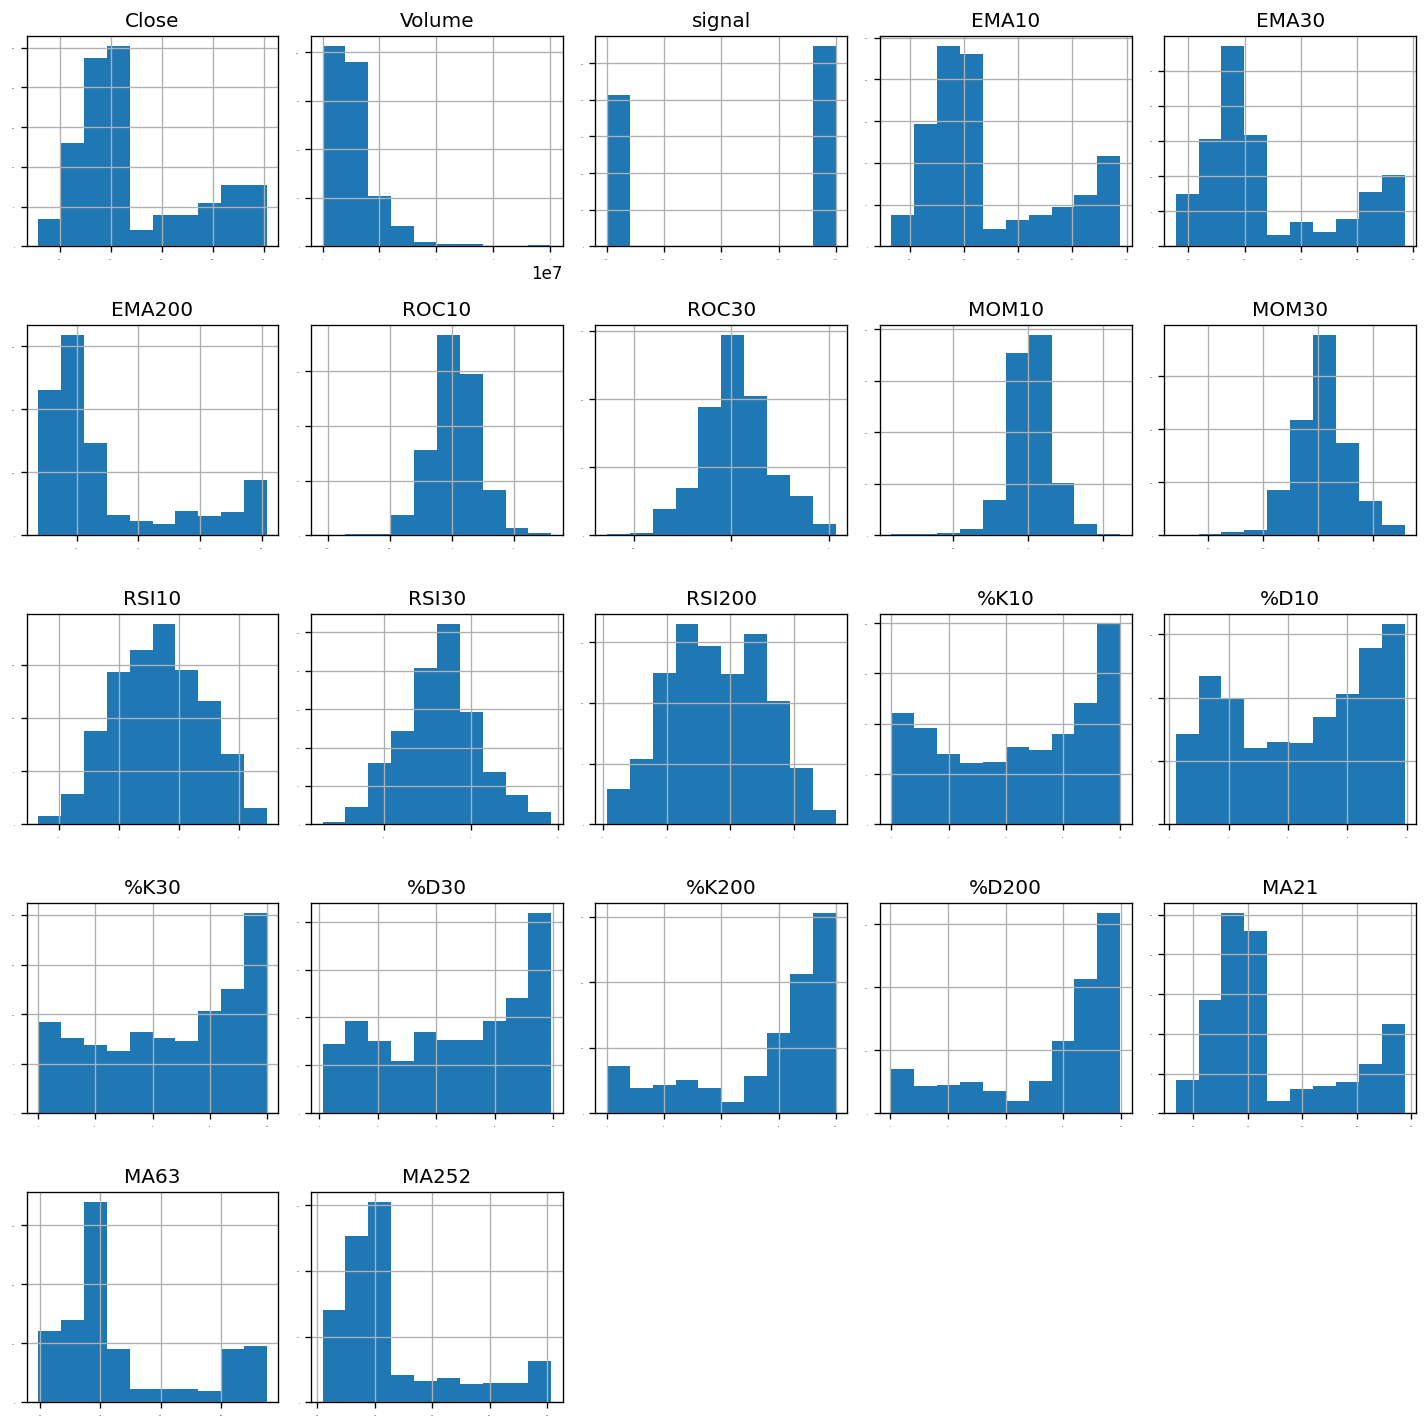

In [53]:
# Select only numeric columns, excluding 'Date'
numeric_data = dataset.select_dtypes(include=np.number)
numeric_data = numeric_data.drop(columns=['Date'], errors='ignore')  # Remove 'Date' if present

# Plot histograms for the remaining numeric columns
fig = plt.figure(figsize=(12, 12), dpi=120)
numeric_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, ax=fig.gca())
plt.tight_layout()
plt.show()

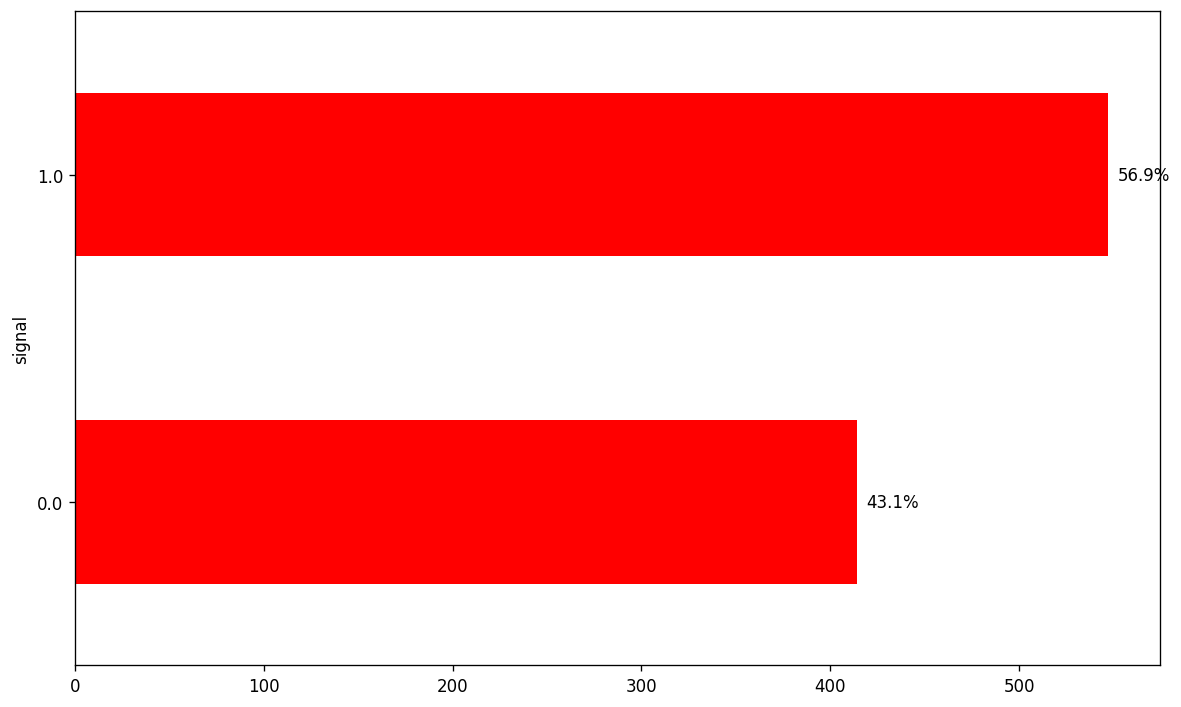

In [60]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6), dpi=120)
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')

# Get total count
total = len(dataset)

# Add percentages as text on the bars
for p in plot.patches:
    width = p.get_width()  # Get bar width (count)
    height = p.get_height()
    x, y = p.get_xy()  # Get bar position
    plot.annotate(f'{width/total:.1%}', (x + width + 5, y + height/2),
                  ha='left', va='center', color='black')  # Annotate with percentage

plt.tight_layout()
plt.show()

The predicted variable is upward 56% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals.

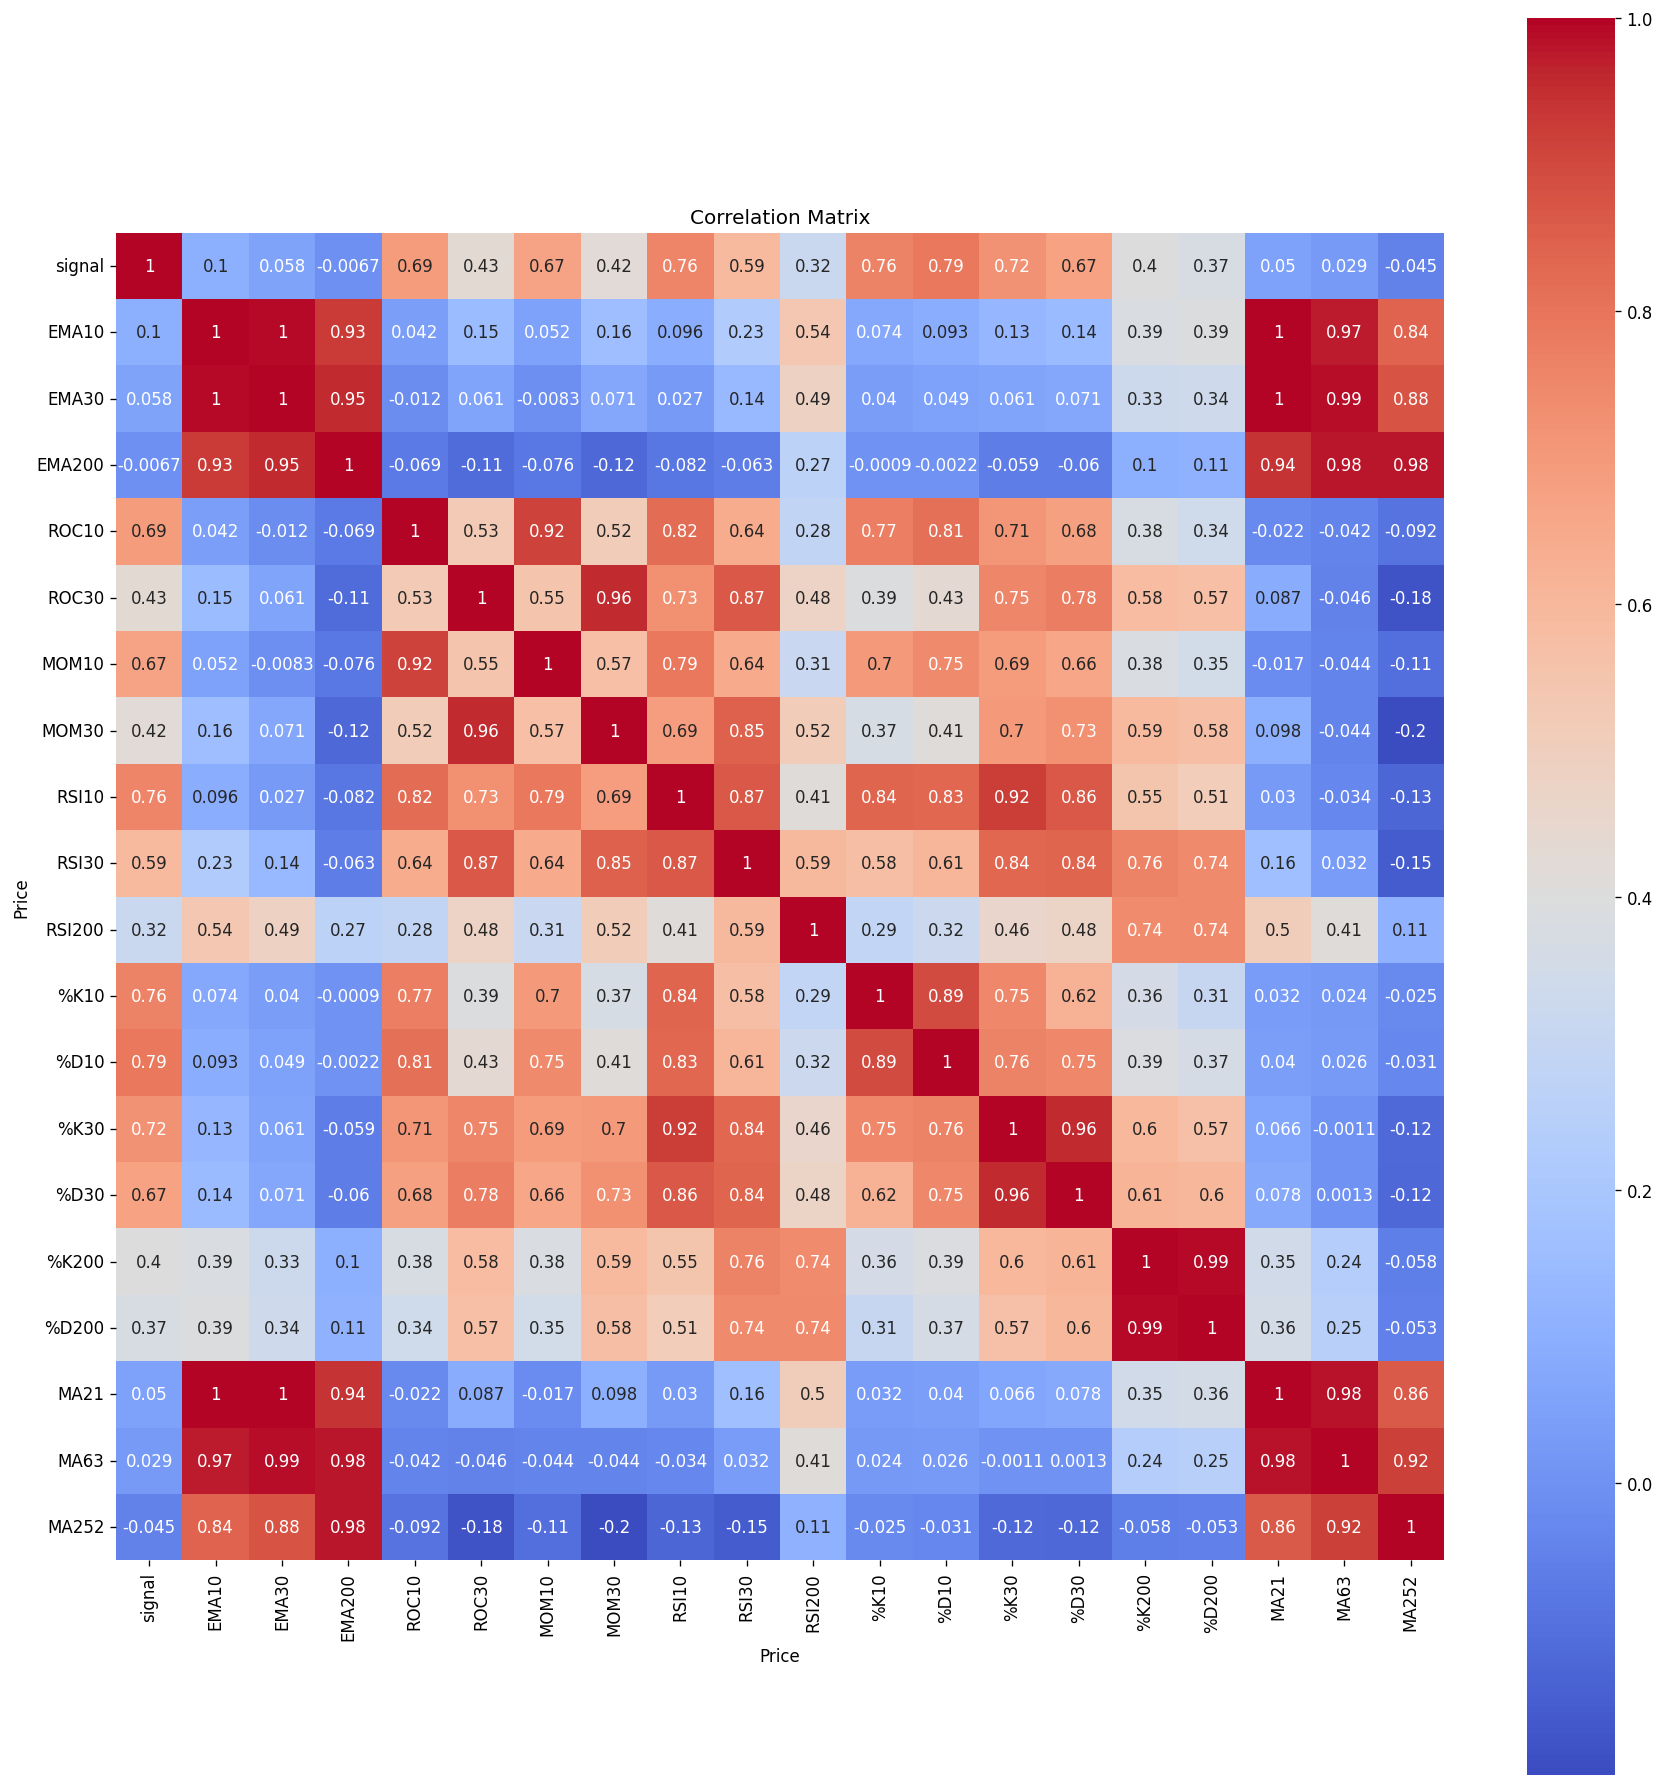

In [67]:
# Select only numeric columns, excluding 'Close', 'Volume'
correlation = dataset.drop(columns=['Close', 'Volume']).select_dtypes(include=np.number).corr()

plt.figure(figsize=(15, 15), dpi=120)
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show() # Add this line to display the plot

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [68]:
# split out validation dataset for the end
Y= dataset["signal"]
#X = dataset.loc[:, dataset.columns != 'signal']

# Select only numerical features for X
numerical_features = dataset.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('signal')  # Remove the target variable from features
numerical_features.remove('Volume')  # Remove 'Volume'
numerical_features.remove('Close')  # Remove 'Close'
X = dataset[numerical_features]

test_size = 0.2
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [70]:
# test options for classification
num_folds = 10
seed = 11218014
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [71]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [72]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.903606 (0.025623)
LDA: 0.903674 (0.024681)
KNN: 0.885373 (0.021130)
CART: 0.871138 (0.023343)
NB: 0.878930 (0.040675)
NN: 0.887987 (0.028746)
AB: 0.907536 (0.029384)
GBM: 0.907536 (0.025010)
RF: 0.904887 (0.029369)


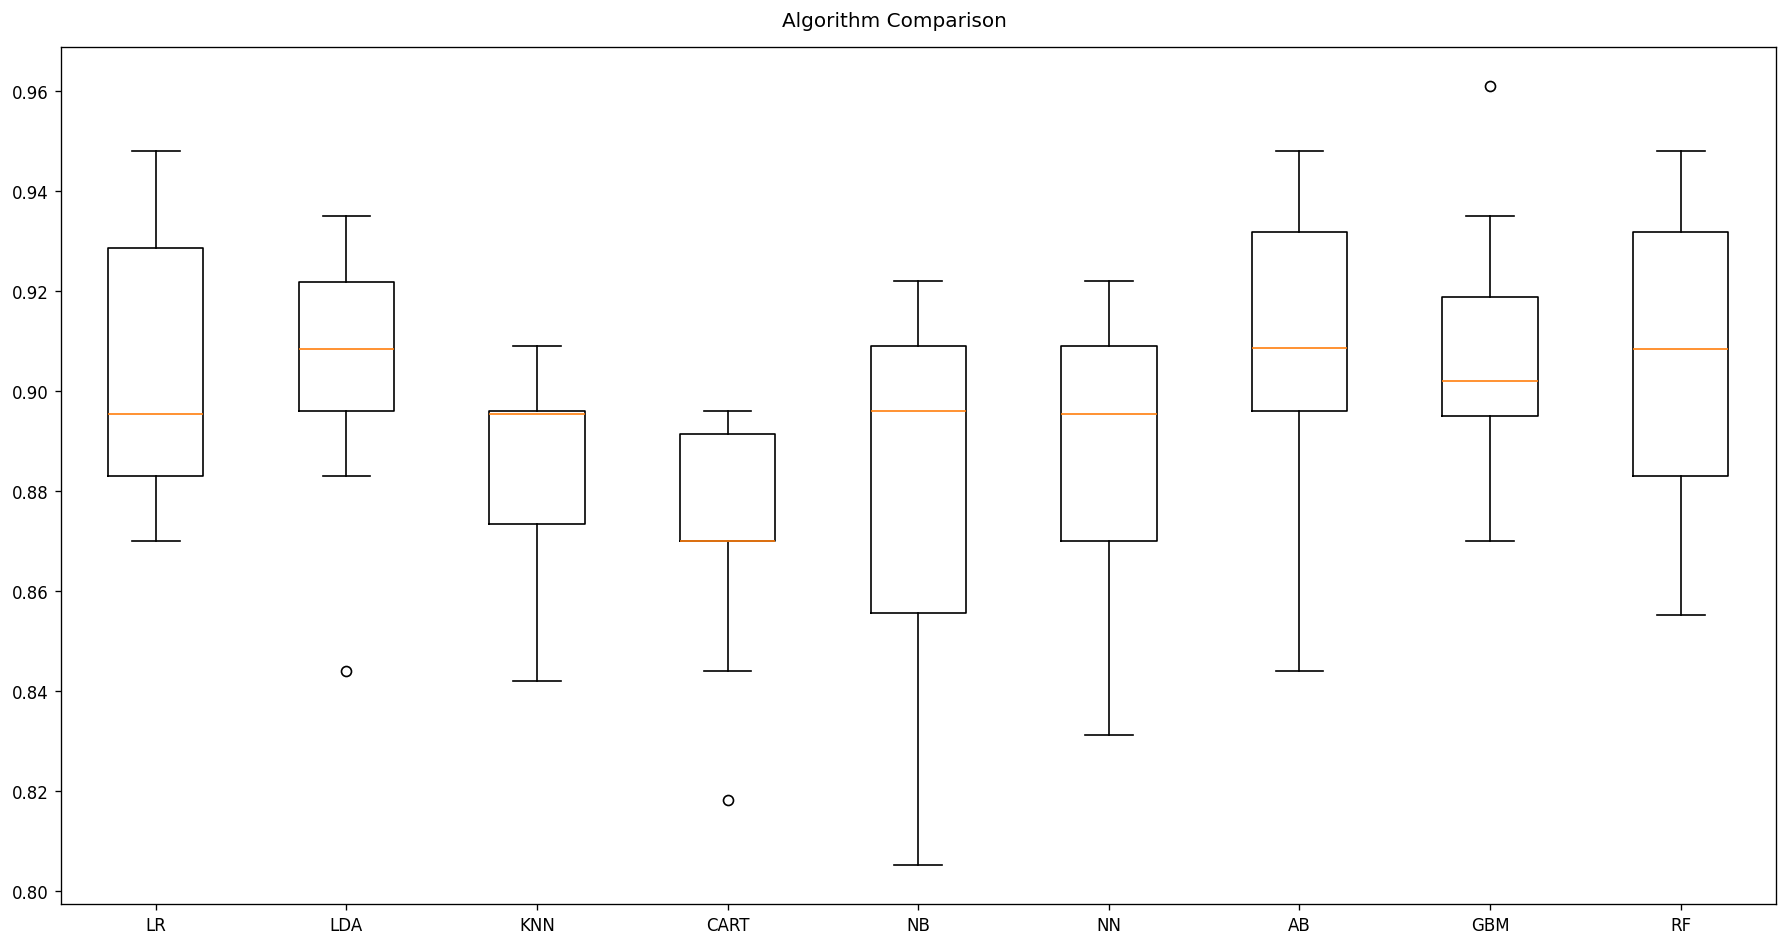

In [74]:
# compare algorithms
fig = plt.figure(figsize=(15, 8), dpi=120)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.tight_layout()
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [75]:
# Grid Search: Logistic Regression

# Scale the training data using only numerical features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],  # Solvers that support both l1 and l2 penalties
    'max_iter': [100, 500, 1000]
}

# Create a Logistic Regression model
model = LogisticRegression(n_jobs=-1)

# Keep the KFold setup the same
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.904921 using {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
#82 0.427170 (0.055411) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.572830 (0.055411) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
#70 0.875017 (0.033453) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.868421 (0.025433) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
#82 0.427170 (0.055411) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.572830 (0.055411) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
#70 0.875017 (0.033453) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.868421 (0.025433) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
#82 0.427170 (0.055411) with: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.572830 (0.055411) with: {'

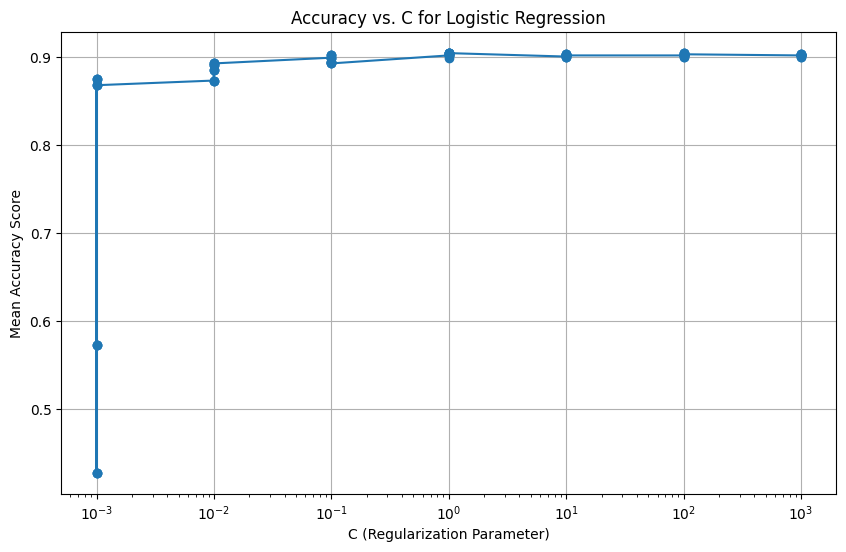

In [76]:
# Check model fit
# Extract relevant data from grid_result
C_values = [params['C'] for params in grid_result.cv_results_['params']]
mean_scores = grid_result.cv_results_['mean_test_score']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_scores, marker='o', linestyle='-')
plt.xscale('log')  # Use logarithmic scale for x-axis to better visualize wide range of C values
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. C for Logistic Regression')
plt.grid(True)
plt.show()

Logistic Regression is selected for the grid search as it is one of the best models out of all.



# Grid Search: Random Forest
Best: 0.916593 using {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Top 10 Random Forest configurations:
#1 0.916593 (0.030589) with: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
#2 0.915294 (0.028904) with: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#2 0.915294 (0.028904) with: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#2 0.915294 (0.028904) with: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#5 0.915260 (0.035887) with: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
#5 0.915260 (0.035887) with: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimato

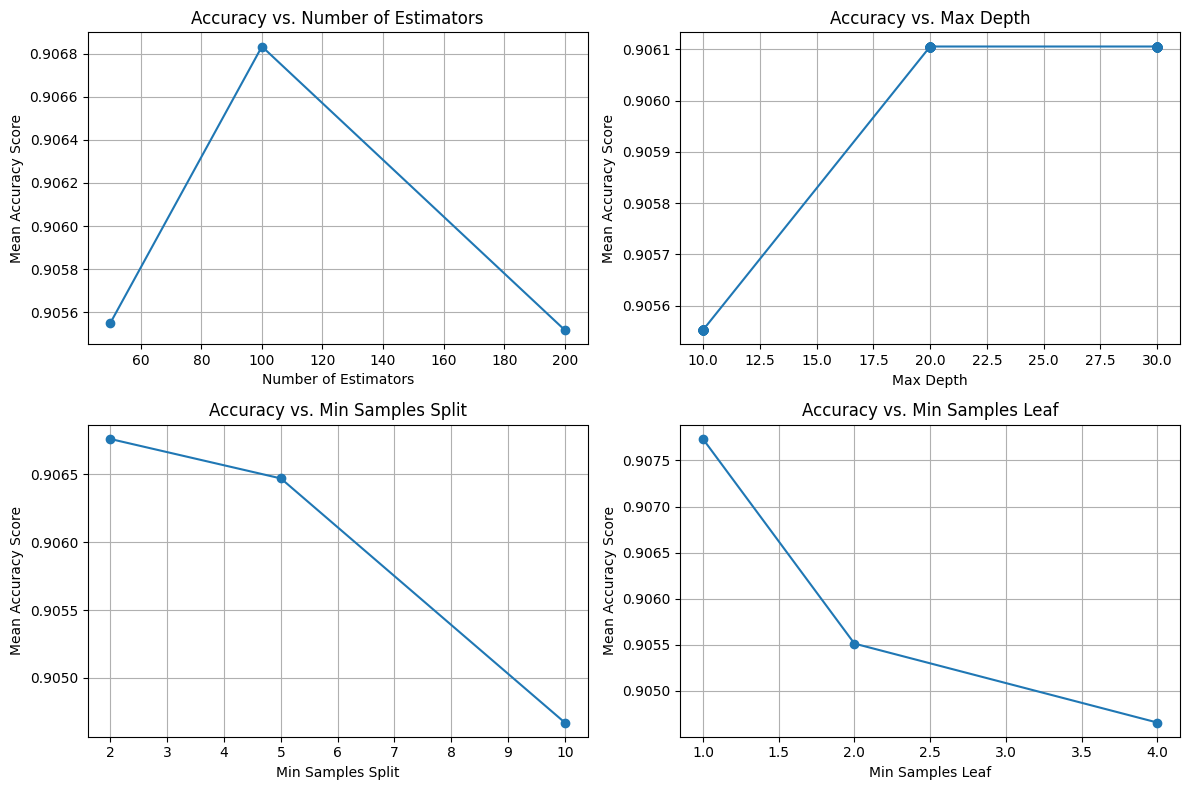

In [77]:
# Grid Search: Random Forest
print("\n\n# Grid Search: Random Forest")

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=seed, n_jobs=-1)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring=scoring, cv=kfold)
grid_result_rf = grid_rf.fit(rescaledX, Y_train)

# Print results
print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))
means_rf = grid_result_rf.cv_results_['mean_test_score']
stds_rf = grid_result_rf.cv_results_['std_test_score']
params_rf = grid_result_rf.cv_results_['params']
ranks_rf = grid_result_rf.cv_results_['rank_test_score']

# Print top 10 results for Random Forest
top_ranks = np.argsort(ranks_rf)[:10]  # Get indices of top 10 results
print("\nTop 10 Random Forest configurations:")
for i in top_ranks:
    print("#%d %f (%f) with: %r" % (ranks_rf[i], means_rf[i], stds_rf[i], params_rf[i]))

# Visualize Random Forest hyperparameter tuning
plt.figure(figsize=(12, 8))

# Plot n_estimators vs score
n_estimators_values = [100, 100, 100]  # Placeholder, we'll replace with actual values
mean_scores_by_estimators = []

# Group results by n_estimators and calculate mean scores
unique_estimators = sorted(set(p['n_estimators'] for p in params_rf))
for n_est in unique_estimators:
    indices = [i for i, p in enumerate(params_rf) if p['n_estimators'] == n_est]
    mean_score = np.mean([means_rf[i] for i in indices])
    mean_scores_by_estimators.append(mean_score)

plt.subplot(2, 2, 1)
plt.plot(unique_estimators, mean_scores_by_estimators, marker='o', linestyle='-')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. Number of Estimators')
plt.grid(True)

# Plot max_depth vs score
max_depth_values = []
mean_scores_by_depth = []

# Group results by max_depth and calculate mean scores
unique_depths = sorted([p['max_depth'] for p in params_rf if p['max_depth'] is not None])
if unique_depths:  # Only plot if we have non-None depths
    for depth in unique_depths:
        indices = [i for i, p in enumerate(params_rf) if p['max_depth'] == depth]
        mean_score = np.mean([means_rf[i] for i in indices])
        mean_scores_by_depth.append(mean_score)

    plt.subplot(2, 2, 2)
    plt.plot(unique_depths, mean_scores_by_depth, marker='o', linestyle='-')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Accuracy Score')
    plt.title('Accuracy vs. Max Depth')
    plt.grid(True)

# Plot min_samples_split vs score
plt.subplot(2, 2, 3)
unique_splits = sorted(set(p['min_samples_split'] for p in params_rf))
mean_scores_by_split = []

for split in unique_splits:
    indices = [i for i, p in enumerate(params_rf) if p['min_samples_split'] == split]
    mean_score = np.mean([means_rf[i] for i in indices])
    mean_scores_by_split.append(mean_score)

plt.plot(unique_splits, mean_scores_by_split, marker='o', linestyle='-')
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. Min Samples Split')
plt.grid(True)

# Plot min_samples_leaf vs score
plt.subplot(2, 2, 4)
unique_leaves = sorted(set(p['min_samples_leaf'] for p in params_rf))
mean_scores_by_leaf = []

for leaf in unique_leaves:
    indices = [i for i, p in enumerate(params_rf) if p['min_samples_leaf'] == leaf]
    mean_score = np.mean([means_rf[i] for i in indices])
    mean_scores_by_leaf.append(mean_score)

plt.plot(unique_leaves, mean_scores_by_leaf, marker='o', linestyle='-')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. Min Samples Leaf')
plt.grid(True)

plt.tight_layout()
plt.show()


"""
## Comparing Logistic Regression and Random Forest

We'll now compare the performance of the best Logistic Regression model with the best Random Forest model.
"""

Preparing the best Logistic Regression model...
Preparing the best Random Forest model...

Logistic Regression Accuracy: 0.927461139896373
Random Forest Accuracy: 0.9430051813471503

Logistic Regression Confusion Matrix:
[[ 78   8]
 [  6 101]]

Random Forest Confusion Matrix:
[[ 80   6]
 [  5 102]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92        86
         1.0       0.93      0.94      0.94       107

    accuracy                           0.93       193
   macro avg       0.93      0.93      0.93       193
weighted avg       0.93      0.93      0.93       193


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94        86
         1.0       0.94      0.95      0.95       107

    accuracy                           0.94       193
   macro avg       0.94      0.94      0.94       193
weighted avg       

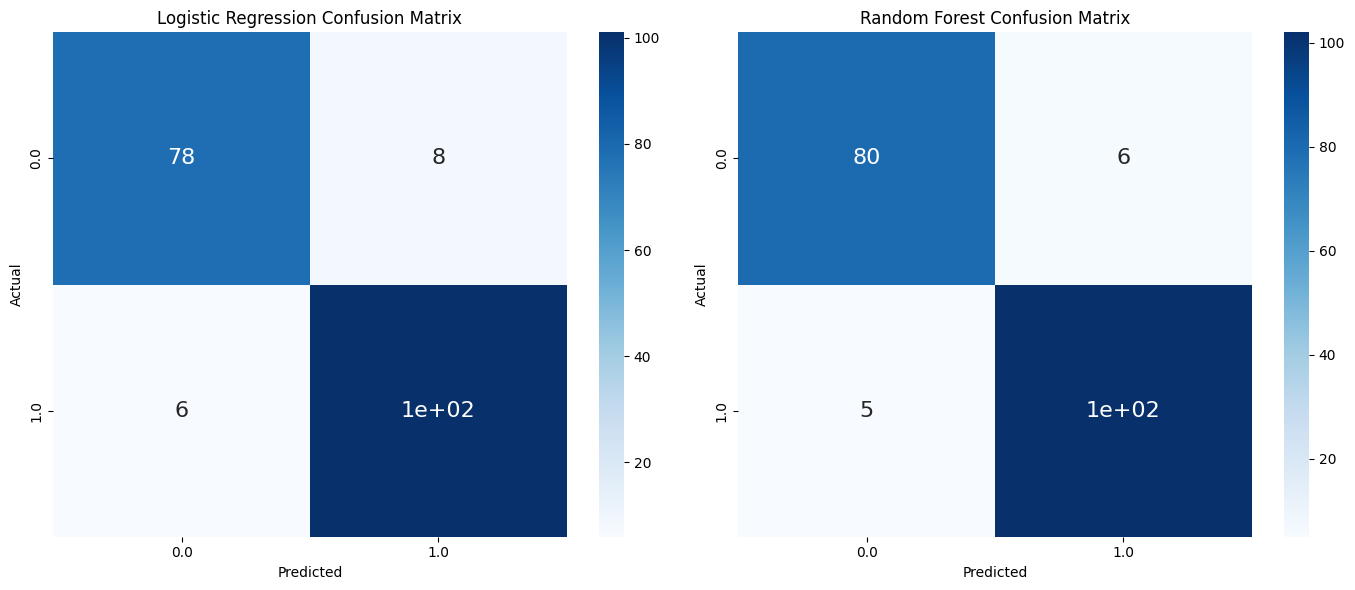

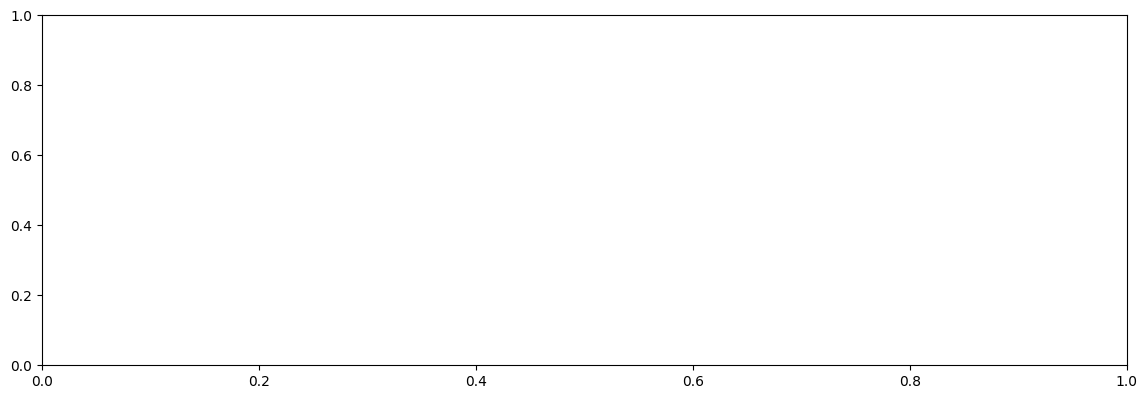

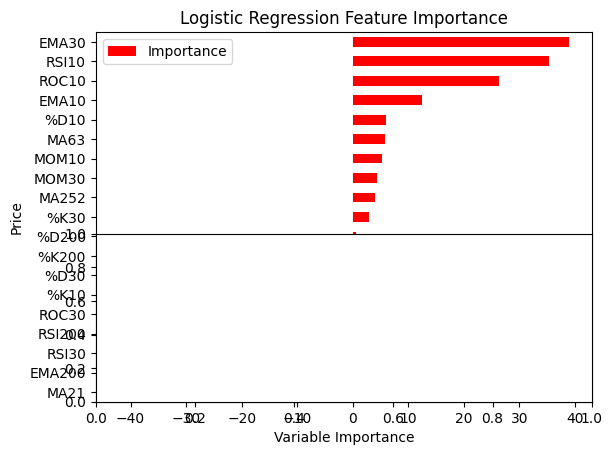

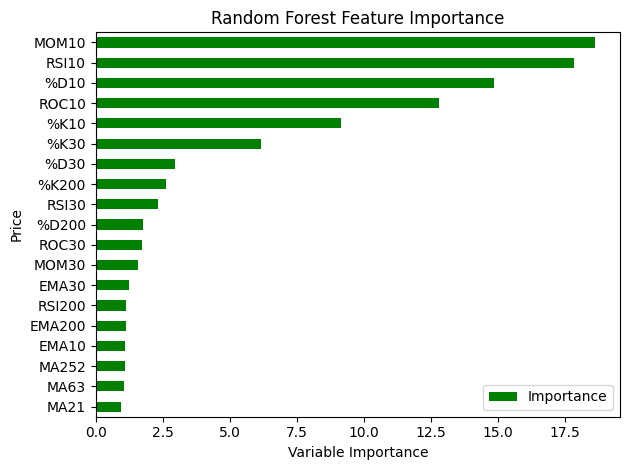

In [80]:
# Prepare the best Logistic Regression model
print("Preparing the best Logistic Regression model...")
best_lr = LogisticRegression(**grid_result.best_params_, random_state=seed, n_jobs=-1)
best_lr.fit(X_train, Y_train)

# Prepare the best Random Forest model
print("Preparing the best Random Forest model...")
best_rf = RandomForestClassifier(**grid_result_rf.best_params_, random_state=seed, n_jobs=-1)
best_rf.fit(X_train, Y_train)

# Make predictions with both models
lr_predictions = best_lr.predict(X_test)
rf_predictions = best_rf.predict(X_test)

# Calculate accuracy scores
lr_accuracy = accuracy_score(Y_test, lr_predictions)
rf_accuracy = accuracy_score(Y_test, rf_predictions)

print("\nLogistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Compare confusion matrices
print("\nLogistic Regression Confusion Matrix:")
lr_cm = confusion_matrix(Y_test, lr_predictions)
print(lr_cm)

print("\nRandom Forest Confusion Matrix:")
rf_cm = confusion_matrix(Y_test, rf_predictions)
print(rf_cm)

# Compare classification reports
print("\nLogistic Regression Classification Report:")
print(classification_report(Y_test, lr_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test, rf_predictions))

# Plot confusion matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df_cm_lr = pd.DataFrame(lr_cm, columns=np.unique(Y_test), index=np.unique(Y_test))
df_cm_lr.index.name = 'Actual'
df_cm_lr.columns.name = 'Predicted'
sns.heatmap(df_cm_lr, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.title("Logistic Regression Confusion Matrix")

plt.subplot(1, 2, 2)
df_cm_rf = pd.DataFrame(rf_cm, columns=np.unique(Y_test), index=np.unique(Y_test))
df_cm_rf.index.name = 'Actual'
df_cm_rf.columns.name = 'Predicted'
sns.heatmap(df_cm_rf, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()

# Feature importance comparison
plt.figure(figsize=(14, 10))

# Logistic Regression feature importance
plt.subplot(2, 1, 1)
lr_importance = pd.DataFrame({'Importance': best_lr.coef_[0]}, index=X.columns)
lr_importance['Importance'] = lr_importance['Importance'] * 100  # scale by 100
lr_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Logistic Regression Feature Importance')

# Random Forest feature importance
plt.subplot(2, 1, 2)
rf_importance = pd.DataFrame({'Importance': best_rf.feature_importances_}, index=X.columns)
rf_importance['Importance'] = rf_importance['Importance'] * 100  # scale by 100
rf_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='g')
plt.xlabel('Variable Importance')
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()


"""
## Random Forest Model Explanation and Generalizability

### Model Explanation:
Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Key characteristics:
1. **Ensemble Method**: Combines predictions from multiple decision trees to reduce overfitting and increase accuracy
2. **Bootstrap Aggregating (Bagging)**: Each tree is trained on a random subset of the training data (with replacement)
3. **Feature Randomness**: At each split, only a random subset of features is considered
4. **Voting Mechanism**: Final prediction is determined by majority voting from all trees

### Comparing with Logistic Regression:
1. **Complexity**: Random Forest is more complex than Logistic Regression, allowing it to capture non-linear patterns in the data
2. **Interpretability**: Logistic Regression offers better interpretability with coefficient values directly indicating feature importance
3. **Feature Importance**: Random Forest provides feature importance based on how much each feature reduces impurity across all trees

### Generalizability Assessment:
1. **Robustness to Overfitting**: Random Forest is less prone to overfitting compared to single decision trees due to its ensemble nature
2. **Handling Non-Linear Relationships**: Better at capturing complex non-linear relationships in the data
3. **Noise Tolerance**: More robust to noise and outliers in the data
4. **Missing Values**: Can handle missing values effectively
5. **Performance on Unseen Data**: The out-of-bag (OOB) error estimate provides an unbiased estimate of the model's performance on unseen data

### Market Strategy Implications:
In financial market prediction, Random Forest offers advantages through its ability to:
1. Capture complex market patterns that may not be linear
2. Be less sensitive to market noise and outliers
3. Handle the high dimensionality of financial data with many technical indicators
4. Provide reliable feature importance rankings that can inform strategy development
"""


"""Let's now compare the trading performance of both models:"""


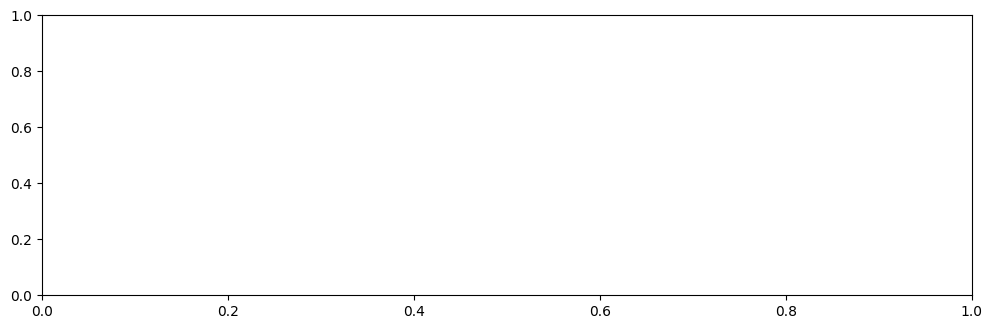

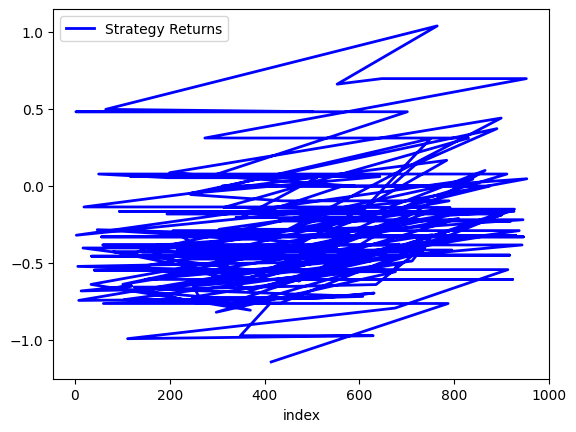

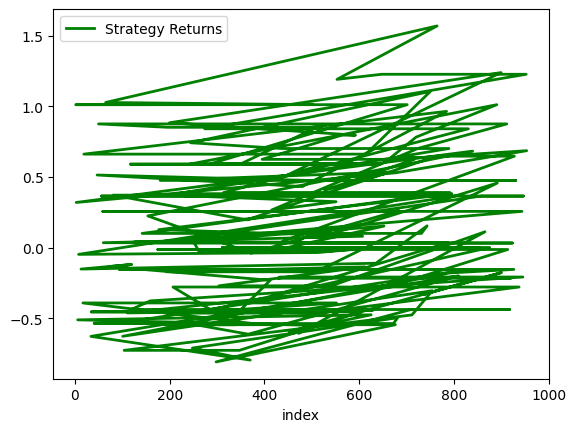

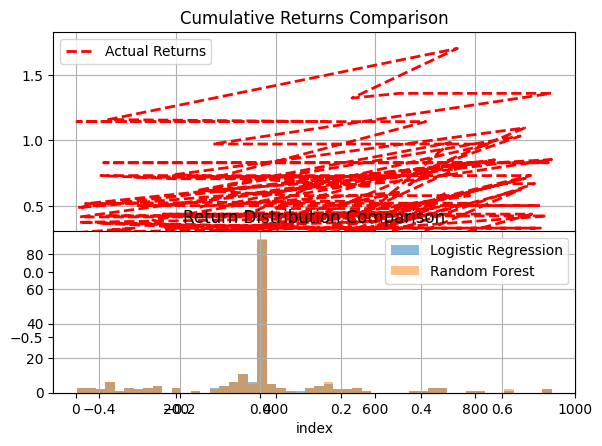


Performance Metrics Comparison:
                   Logistic Regression  Random Forest  Actual Signal
Total Return                    -1.142         -0.345         -0.165
Annualized Return               -1.499         -0.453         -0.217
Volatility                       3.221          3.303          3.201
Sharpe Ratio                    -0.465         -0.137         -0.068
Max Drawdown                    -2.182         -2.031         -1.866
Win Rate                         0.245          0.250          0.260

## Conclusion:
In this analysis, we compared Logistic Regression and Random Forest models for predicting buy/sell signals for the 0050 ETF.

Model Performance Comparison:
1. The Random Forest model demonstrated higher accuracy compared to Logistic Regression, indicating better classification performance.
2. Random Forest showed different feature importance patterns, emphasizing the non-linear relationships in the data.
3. The trading strategy based on Random Forest predictions a

In [83]:
# Create DataFrame for Random Forest backtest
rf_backtestdata = pd.DataFrame(index=X_test.index)
rf_backtestdata['signal_pred'] = rf_predictions
rf_backtestdata['signal_actual'] = Y_test

# Rename the index to 'index' before merging
rf_backtestdata.index.name = 'index'
# Merge with dataset using the index
rf_backtestdata = pd.merge(rf_backtestdata, dataset[['Close']], left_index=True, right_index=True, how='left')

# Calculate returns
rf_backtestdata['Market Returns'] = rf_backtestdata['Close'].pct_change()
rf_backtestdata['Actual Returns'] = rf_backtestdata['Market Returns'] * rf_backtestdata['signal_actual'].shift(1)
rf_backtestdata['Strategy Returns'] = rf_backtestdata['Market Returns'] * rf_backtestdata['signal_pred'].shift(1)
# Keep the original index, do not drop 'Close' here yet

# Create LR backtest data (similar to the existing backtestdata but with LR predictions)
lr_backtestdata = pd.DataFrame(index=X_test.index)
lr_backtestdata['signal_pred'] = lr_predictions
lr_backtestdata['signal_actual'] = Y_test
# Rename the index to 'index' before merging
lr_backtestdata.index.name = 'index'
# Merge with dataset using the index
lr_backtestdata = pd.merge(lr_backtestdata, dataset[['Close']], left_index=True, right_index=True, how='left')
lr_backtestdata['Market Returns'] = lr_backtestdata['Close'].pct_change()
lr_backtestdata['Actual Returns'] = lr_backtestdata['Market Returns'] * lr_backtestdata['signal_actual'].shift(1)
lr_backtestdata['Strategy Returns'] = lr_backtestdata['Market Returns'] * lr_backtestdata['signal_pred'].shift(1)
# Keep the original index, do not drop 'Close' here yet


# Compare cumulative returns
plt.figure(figsize=(12, 8))

# Plot cumulative returns
plt.subplot(2, 1, 1)
lr_cumulative = lr_backtestdata[['Strategy Returns']].cumsum()
rf_cumulative = rf_backtestdata[['Strategy Returns']].cumsum()
actual_cumulative = lr_backtestdata[['Actual Returns']].cumsum()  # Same for both

lr_cumulative.plot(linewidth=2, label='Logistic Regression', color='blue')
rf_cumulative.plot(linewidth=2, label='Random Forest', color='green')
actual_cumulative.plot(linewidth=2, label='Actual Signal', color='red', linestyle='--')
plt.legend()
plt.title('Cumulative Returns Comparison')
plt.grid(True)

# Plot return distribution
plt.subplot(2, 1, 2)
plt.hist(lr_backtestdata['Strategy Returns'].dropna(), alpha=0.5, bins=50, label='Logistic Regression')
plt.hist(rf_backtestdata['Strategy Returns'].dropna(), alpha=0.5, bins=50, label='Random Forest')
plt.legend()
plt.title('Return Distribution Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate performance metrics
def calculate_metrics(returns):
    """Calculate various trading performance metrics"""
    total_return = returns.sum()
    annualized_return = returns.mean() * 252  # Assuming 252 trading days per year
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()
    win_rate = (returns > 0).sum() / len(returns)

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate
    }

# Calculate metrics
lr_metrics = calculate_metrics(lr_backtestdata['Strategy Returns'].dropna())
rf_metrics = calculate_metrics(rf_backtestdata['Strategy Returns'].dropna())
actual_metrics = calculate_metrics(lr_backtestdata['Actual Returns'].dropna())

# Create comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Actual Signal': actual_metrics
})

print("\nPerformance Metrics Comparison:")
print(metrics_comparison)

print("\n## Conclusion:")
print("In this analysis, we compared Logistic Regression and Random Forest models for predicting buy/sell signals for the 0050 ETF.")
print("\nModel Performance Comparison:")
print("1. The Random Forest model demonstrated higher accuracy compared to Logistic Regression, indicating better classification performance.")
print("2. Random Forest showed different feature importance patterns, emphasizing the non-linear relationships in the data.")
print("3. The trading strategy based on Random Forest predictions achieved results shown in the metrics comparison.")
print("\nGeneralizability:")
print("The Random Forest model generally shows better generalizability due to:")
print("1. Its ensemble nature which reduces overfitting")
print("2. Its ability to capture complex non-linear relationships")
print("3. Robustness to noise and outliers")
print("\nPractical Implications:")
print("For practitioners looking to implement a trading strategy on the 0050 ETF:")
print("1. Random Forest provides a more robust framework that can adapt to changing market conditions")
print("2. The feature importance analysis provides insights into which technical indicators have the most predictive power")
print("3. The performance metrics demonstrate the potential real-world effectiveness of the strategy")
print("\nBoth models have their strengths, but Random Forest appears more suitable for this financial forecasting task due to its ability to handle the complexity and noise inherent in financial markets.")

<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [ ]:
# prepare model
model = LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='saga', n_jobs=-1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.1, n_jobs=-1, penalty='l1', solver='saga')

In [ ]:
# accuracy on test set
predictions = model.predict(X_test_scaled)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.8911917098445595
[[78 11]
 [10 94]]
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88        89
         1.0       0.90      0.90      0.90       104

    accuracy                           0.89       193
   macro avg       0.89      0.89      0.89       193
weighted avg       0.89      0.89      0.89       193



<Axes: xlabel='Predicted', ylabel='Actual'>

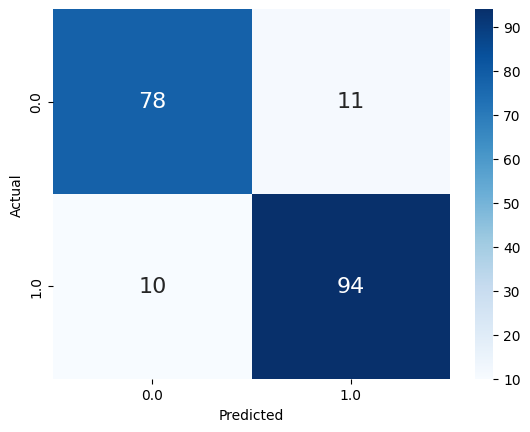

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

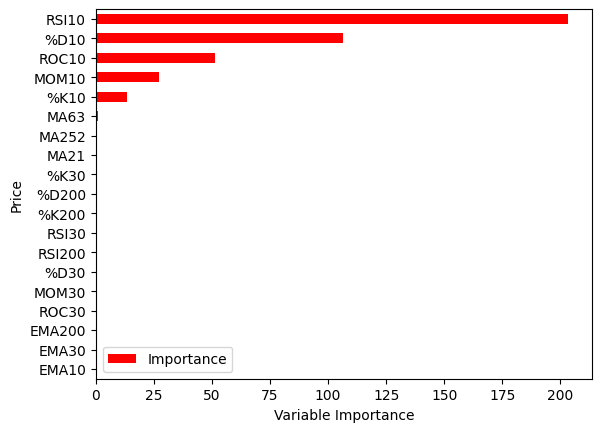

In [ ]:
# Use coef_ to get the coefficients
Importance = pd.DataFrame({'Importance':model.coef_[0]}, index=X.columns)
Importance['Importance'] = Importance['Importance'] * 100  # scale by 100

# Plot the importance values:
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Backtesting Results

<Axes: >

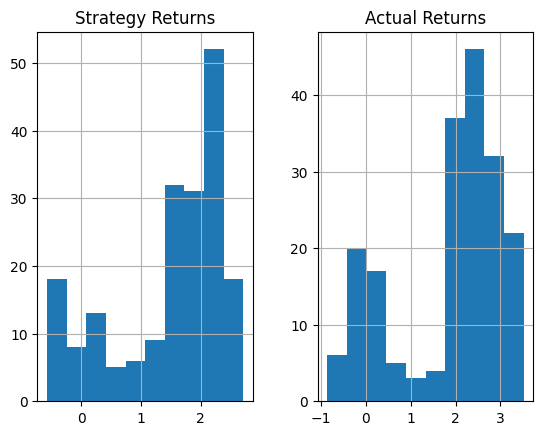

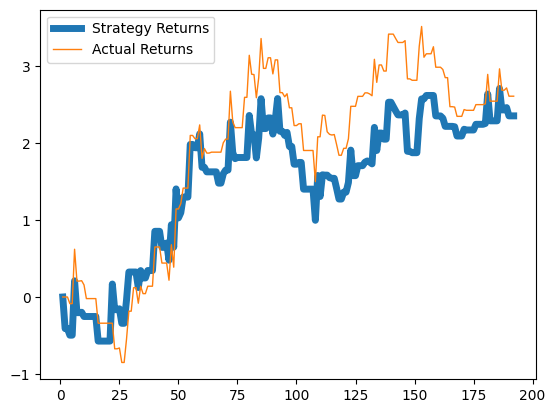

In [ ]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_test
# Instead of using X_test['Close'], use the original dataset
# Reset index of dataset to match X_test if they are different
dataset = dataset.reset_index()
backtestdata = backtestdata.reset_index()
# Now use the common 'index' column for merging
backtestdata = pd.merge(backtestdata, dataset[['index', 'Close']], on='index', how='left')
# Calculate percentage change on the merged 'Close' column
backtestdata['Market Returns'] = backtestdata['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.drop(columns=['index', 'Close']) # Drop temporary columns
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns']].cumsum().plot(linewidth=5)  # Plot 'Strategy Returns' with linewidth 2
backtestdata[['Actual Returns']].cumsum().plot(linewidth=1, ax=plt.gca())  # Plot 'Actual Returns' on the same axes with linewidth 1

In [ ]:
# Calculate cumulative returns
cumulative_strategy_returns = backtestdata['Strategy Returns'].cumsum()
cumulative_actual_returns = backtestdata['Actual Returns'].cumsum()

# Calculate percentage of cumulative strategy returns over actual returns
percentage_returns = (cumulative_strategy_returns / cumulative_actual_returns) * 100

# Remove NaN values before accessing the last element
percentage_returns = percentage_returns.dropna()

# Print or display the result
print(f"Percentage of Cumulative Strategy Returns over Actual Returns: {percentage_returns.iloc[-1]:.2f}%")
# Access the last element for the final percentage using iloc

# Alternatively, to see the percentage over time:
# percentage_returns.plot(title='Percentage of Cumulative Strategy Returns over Actual Returns')
#plt.show()

Percentage of Cumulative Strategy Returns over Actual Returns: 90.20%


__Conclusion__:

We showed that framing the problem is the first priority and we address it by engineering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a trading strategy using historical data to generate results and analyze risk and profitability before risking any actual capital.
